In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Create the cache directory if it doesn't exist
cache_dir = '/content/drive/MyDrive/FastF1_cache'
os.makedirs(cache_dir, exist_ok=True)
!pip install optuna joblib

!pip install fastf1
import fastf1 as f1

# Enable caching on Google Drive
f1.Cache.enable_cache(cache_dir)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 1.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import optuna
import joblib

# Load combined pit stop preprocessed data (2021-2023)
data_path = '/content/drive/MyDrive/ML_Project/Combined_PitStop_Preprocessed_2021_2023.csv'
df = pd.read_csv(data_path)

# Drop rows with missing key columns
df = df.dropna(subset=["PitStopLapTimeRatio", "PitStopCount", "AvgPitDuration", "TotalPitDuration",
                         "AvgTyreLife", "AvgLapTime", "AvgPrevLapTime", "AvgNextLapTime"])

# Define features and target
features = ["PitStopCount", "AvgPitDuration", "TotalPitDuration", "AvgTyreLife",
            "AvgLapTime", "AvgPrevLapTime", "AvgNextLapTime"]
target = "PitStopLapTimeRatio"
X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna using suggest_float (log=True) instead of deprecated methods
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []
    for train_idx, valid_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = xgb.XGBRegressor(**params, random_state=42, n_estimators=1000)
        # Trying early stopping; if not supported, proceed without it
        try:
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
        except TypeError:
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
    return np.mean(rmses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

print("Best trial:")
trial = study.best_trial
print("  RMSE: {:.4f}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params["objective"] = "reg:squarederror"
best_params["eval_metric"] = "rmse"
best_params["tree_method"] = "hist"

final_model = xgb.XGBRegressor(**best_params, random_state=42, n_estimators=1000)
try:
    final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)
except TypeError:
    final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

y_pred = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Final RMSE on test set:", final_rmse)

model_path = "/content/drive/MyDrive/ML_Project/pitstop_model_xgb.pkl"
joblib.dump(final_model, model_path)
print("Model saved to", model_path)


[I 2025-03-30 06:58:51,424] A new study created in memory with name: no-name-a2fe493e-49bd-4ef6-8993-9085bc877205
[I 2025-03-30 06:58:53,470] Trial 0 finished with value: 1.5592682839737158 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2267523923216585, 'subsample': 0.9470370486905342, 'colsample_bytree': 0.5001358059829983, 'lambda': 0.13620243887889757, 'alpha': 0.0012148501555107173}. Best is trial 0 with value: 1.5592682839737158.
[I 2025-03-30 07:06:14,967] Trial 1 finished with value: 0.39154581371372543 and parameters: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.01363177556163599, 'subsample': 0.6381595454532273, 'colsample_bytree': 0.8103528022310131, 'lambda': 3.2931766443096344, 'alpha': 0.1071268310577648}. Best is trial 1 with value: 0.39154581371372543.
[I 2025-03-30 07:13:21,418] Trial 2 finished with value: 0.9469991779421868 and parameters: {'booster': 'dart', 'max_depth': 8, 'learning_rate': 0.06189679415718235, 'subsample': 0.7158

Best trial:
  RMSE: 0.3915
  Params:
    booster: dart
    max_depth: 6
    learning_rate: 0.01363177556163599
    subsample: 0.6381595454532273
    colsample_bytree: 0.8103528022310131
    lambda: 3.2931766443096344
    alpha: 0.1071268310577648
[0]	validation_0-rmse:3.65124
[1]	validation_0-rmse:3.61413
[2]	validation_0-rmse:3.58010
[3]	validation_0-rmse:3.55246
[4]	validation_0-rmse:3.51554
[5]	validation_0-rmse:3.47823
[6]	validation_0-rmse:3.44459
[7]	validation_0-rmse:3.41279
[8]	validation_0-rmse:3.37758
[9]	validation_0-rmse:3.35336
[10]	validation_0-rmse:3.31826
[11]	validation_0-rmse:3.28521
[12]	validation_0-rmse:3.25269
[13]	validation_0-rmse:3.21915
[14]	validation_0-rmse:3.19541
[15]	validation_0-rmse:3.16319
[16]	validation_0-rmse:3.13077
[17]	validation_0-rmse:3.09988
[18]	validation_0-rmse:3.08542
[19]	validation_0-rmse:3.05710
[20]	validation_0-rmse:3.03116
[21]	validation_0-rmse:2.99994
[22]	validation_0-rmse:2.97124
[23]	validation_0-rmse:2.94189
[24]	validation_0-r

Pit stop strategy report saved to /content/drive/MyDrive/ML_Project/PitStop_Strategy_Report_2024.csv


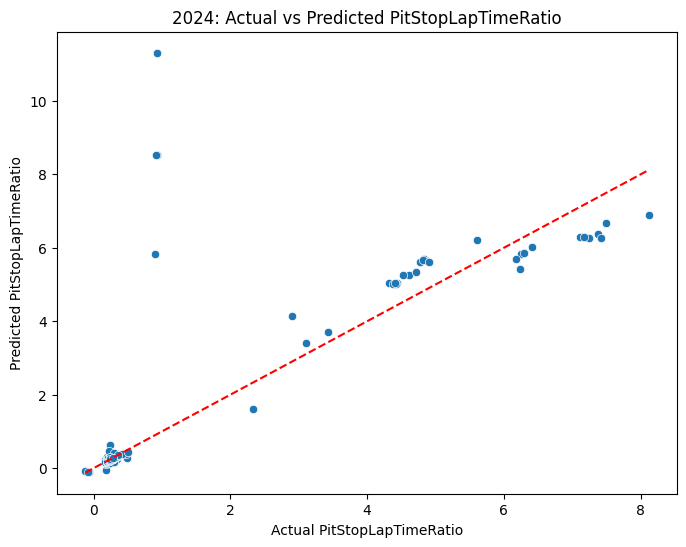

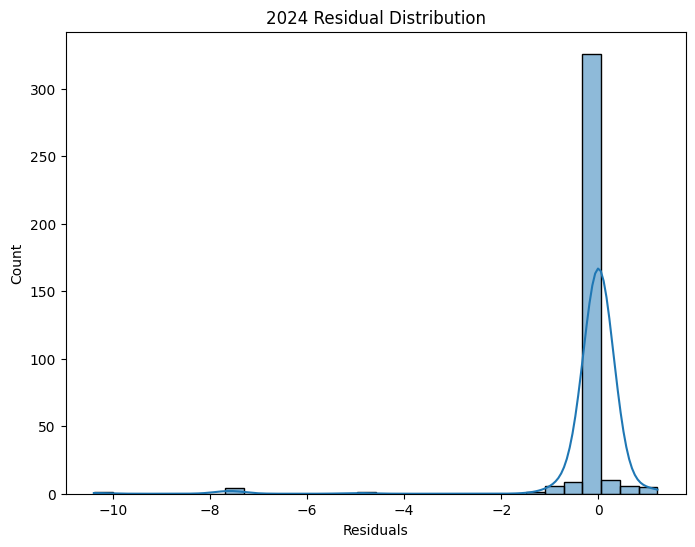

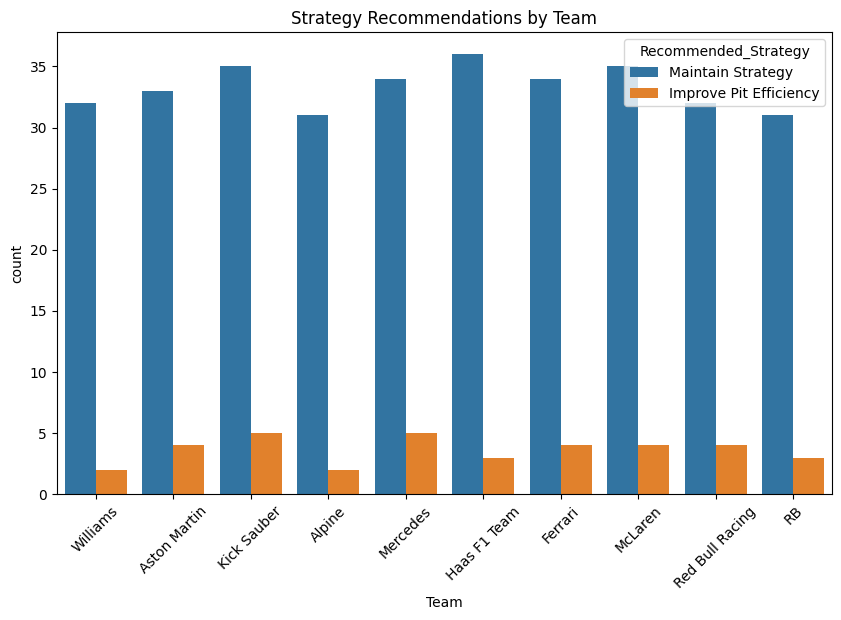

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import joblib

# Load 2024 preprocessed pit stop data
df_2024 = pd.read_csv('/content/drive/MyDrive/ML_Project/2024_Pitstop_Preprocessed.csv')
df_2024 = df_2024.dropna(subset=["PitStopLapTimeRatio", "PitStopCount", "AvgPitDuration",
                                   "TotalPitDuration", "AvgTyreLife", "AvgLapTime",
                                   "AvgPrevLapTime", "AvgNextLapTime"])

# Define features and target
features = ["PitStopCount", "AvgPitDuration", "TotalPitDuration", "AvgTyreLife",
            "AvgLapTime", "AvgPrevLapTime", "AvgNextLapTime"]
target = "PitStopLapTimeRatio"
X_2024 = df_2024[features]
y_2024 = df_2024[target]

# Load the trained model
model_path = "/content/drive/MyDrive/ML_Project/pitstop_model_xgb.pkl"
model = joblib.load(model_path)

# Predict on 2024 data and compute residuals
df_2024["Predicted_PitStopLapTimeRatio"] = model.predict(X_2024)
df_2024["Residual"] = df_2024["PitStopLapTimeRatio"] - df_2024["Predicted_PitStopLapTimeRatio"]

# Generate strategy recommendations (example rule)
threshold = 1.0  # Adjust based on domain insights
df_2024["Recommended_Strategy"] = df_2024["Predicted_PitStopLapTimeRatio"].apply(
    lambda x: "Improve Pit Efficiency" if x > threshold else "Maintain Strategy"
)

# Detailed report: Group by Team and Driver
# Aggregate actual and predicted pit stop lap time ratios and compute difference
report = df_2024.groupby(["Team", "Driver"]).agg({
    "PitStopCount": "mean",
    "AvgPitDuration": "mean",
    "TotalPitDuration": "mean",
    "AvgTyreLife": "mean",
    "AvgLapTime": "mean",
    "AvgPrevLapTime": "mean",
    "AvgNextLapTime": "mean",
    "PitStopLapTimeRatio": "mean",
    "Predicted_PitStopLapTimeRatio": "mean",
    "Recommended_Strategy": lambda x: x.mode()[0] if len(x.mode()) > 0 else "N/A"
}).reset_index()

# Rename aggregated columns for clarity
report = report.rename(columns={
    "PitStopLapTimeRatio": "Avg_Actual_PitStopLapTimeRatio",
    "Predicted_PitStopLapTimeRatio": "Avg_Predicted_PitStopLapTimeRatio"
})
report["Difference"] = report["Avg_Actual_PitStopLapTimeRatio"] - report["Avg_Predicted_PitStopLapTimeRatio"]

# Save the final report as CSV
report_path = "/content/drive/MyDrive/ML_Project/PitStop_Strategy_Report_2024.csv"
report.to_csv(report_path, index=False)
print("Pit stop strategy report saved to", report_path)

# Visualize Overall Model Performance on 2024 Data

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_2024["PitStopLapTimeRatio"], y=df_2024["Predicted_PitStopLapTimeRatio"])
plt.xlabel("Actual PitStopLapTimeRatio")
plt.ylabel("Predicted PitStopLapTimeRatio")
plt.title("2024: Actual vs Predicted PitStopLapTimeRatio")
plt.plot([df_2024["PitStopLapTimeRatio"].min(), df_2024["PitStopLapTimeRatio"].max()],
         [df_2024["PitStopLapTimeRatio"].min(), df_2024["PitStopLapTimeRatio"].max()], 'r--')
plt.show()

# Residuals distribution
plt.figure(figsize=(8,6))
sns.histplot(df_2024["Residual"], bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("2024 Residual Distribution")
plt.show()

# Visualize strategy recommendations by team
plt.figure(figsize=(10,6))
sns.countplot(x="Team", hue="Recommended_Strategy", data=df_2024)
plt.xticks(rotation=45)
plt.title("Strategy Recommendations by Team")
plt.show()
